#Experiment - degrade knowledge of e and i params and see if we can still pick up K34.

In [8]:
#can we find K34 while assuming basic values for the e and i parameters?
import copy
import numpy as np
import emcee
import corner
import matplotlib.pyplot as p
import astropy.units as u
import funcs

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
#Kepler 34
cb = funcs.CBSystem(m1 = 1.0479,f1 = 1.,m2 = 1.0208,f2 = 0.8475,
                    ab = 0.22882,r1 = 1.1618 * u.Rsun.to('au'),r2 = 1.0927 * u.Rsun.to('au'),
                    eb = 0.52087,ib = np.deg2rad(89.8584),wb = 1.2468,
                    fb = 3.4675,
                    mp = 0.220 * u.Mjup.to('Msun'),ap = 1.0896,rp = 0.764 * u.Rjupiter.to('au'),ep = 0.182,
                    ip = np.deg2rad(90.355),wp = 0.1378,fp = 2.0623,
                    Wp = np.deg2rad(-1.74),
                    t0 = 2454969.2000)
ab0 = cb.ab
mb0 = cb.m1 + cb.m2
p_p0 = (cb.ap**3/(cb.m1+cb.m2))**(1./2.)*365.25 #in days
fp0 = cb.fp
print(1/np.sqrt( (cb.m1+cb.m2)/cb.ab**3 )*365.25)
print(p_p0)

timing_precision = 30./86400./365.25 * (2*np.pi)  #in years/2pi
dt = 0.02
t = np.arange(2454953,2456424,dt)


27.7960087219
288.8298729659465


In [12]:
# make the reference stacked light curve set

#tts = funcs.reb_cb_c(cb,tmin=np.min(t),tmax=np.max(t))
tts = funcs.reb_cb(cb,tmin=np.min(t),tmax=np.max(t))
tts_2,tds_2 = funcs.reb_cb_dvm(cb,0,2,tmin=np.min(t),tmax=np.max(t), timing_precision=timing_precision)
    
ok = tts[:,0] == 20
#ref_tts = tts[ok]
ref_tts = tts_2[tds_2>0]
ref_tds = tds_2[tds_2>0]
print(tts[ok][:,1])
print(ref_tts)

[ 2455227.38035758  2455508.31363919  2455789.78219333  2456075.86253494
  2456366.55162156]
[ 2455227.38082189  2455508.31348844  2455789.78155899  2456075.85928388
  2456366.55246815]


In [5]:
#degrading our knowledge (assume we know eb and wb):
#for now, radii left as we know them - this will change transit durations, and whether some marginal transits happen.

cb.ib = np.pi/2.
cb.ip = np.pi/2.
cb.Wp = 0.0
cb.ep = 0.0
#cb.wp left as is because it defines f_p
cb.mp = 0.0



In [6]:
#now scan across m2/m1, m1+m2, p_p, f_p, as if we were searching.
mratset = np.linspace(cb.m2/cb.m1*0.9,cb.m2/cb.m1*1.1,21)
mtotset = np.linspace(cb.m2+cb.m1*0.9,cb.m1+cb.m2*1.1,5)
ppset = np.linspace(p_p0*0.97,p_p0*1.03,101)
fpset = np.linspace(cb.fp*0.98,cb.fp*1.02,11)

dt = 0.02
t = np.arange(2454953,2456424,dt)

ppset

array([ 280.16497678,  280.3382747 ,  280.51157262,  280.68487055,
        280.85816847,  281.0314664 ,  281.20476432,  281.37806224,
        281.55136017,  281.72465809,  281.89795601,  282.07125394,
        282.24455186,  282.41784979,  282.59114771,  282.76444563,
        282.93774356,  283.11104148,  283.28433941,  283.45763733,
        283.63093525,  283.80423318,  283.9775311 ,  284.15082902,
        284.32412695,  284.49742487,  284.6707228 ,  284.84402072,
        285.01731864,  285.19061657,  285.36391449,  285.53721241,
        285.71051034,  285.88380826,  286.05710619,  286.23040411,
        286.40370203,  286.57699996,  286.75029788,  286.9235958 ,
        287.09689373,  287.27019165,  287.44348958,  287.6167875 ,
        287.79008542,  287.96338335,  288.13668127,  288.30997919,
        288.48327712,  288.65657504,  288.82987297,  289.00317089,
        289.17646881,  289.34976674,  289.52306466,  289.69636258,
        289.86966051,  290.04295843,  290.21625636,  290.38955

In [22]:
tts_all = {}
tds_all = {}

#horrible for loop filling in a 7 fold dict of dicts
for mrat in mratset:
    print(mrat)
    if mrat not in tts_all.keys():
        tts_all[mrat] = {}
        tds_all[mrat] = {}
        
    for mtot in mtotset:
        cb.m2 = mtot / (1 + 1./mrat)
        cb.m1 = mtot / (1 + mrat)
        cb.ab = ab0 * ( (cb.m1+cb.m2)/mb0 )**(1/3.) #force pb to be fixed
        if mtot not in tts_all[mrat].keys():
            tts_all[mrat][mtot] = {}
            tds_all[mrat][mtot] = {}
            
        for pp in ppset:
            cb.ap = ( mtot * (pp/365.25)**2 )**(1./3.)
  
            if pp not in tts_all[mrat][mtot].keys():
                tts_all[mrat][mtot][str(pp)[:6]] = {}
                tds_all[mrat][mtot][str(pp)[:6]] = {}  
                
            for fp in fpset:
                cb.fp = fp
                     
                ttimes, tdurs = funcs.reb_cb_dvm(cb, 0, 2, tmin=np.min(t), 
                                                tmax=np.max(t), timing_precision=timing_precision)
                            
                tts_all[mrat][mtot][str(pp)[:6]][str(fp)[:6]] = ttimes[tdurs>0]
                tds_all[mrat][mtot][str(pp)[:6]][str(fp)[:6]] = tdurs[tdurs>0]

0.876724878328
0.886466265865
0.896207653402
0.905949040939
0.915690428476
0.925431816013
0.93517320355
0.944914591087
0.954655978624
0.964397366161
0.974138753698
0.983880141235
0.993621528772
1.00336291631
1.01310430385
1.02284569138
1.03258707892
1.04232846646
1.05206985399
1.06181124153
1.07155262907


In [7]:
print(ref_tts)
print(np.sum(ref_tds))
print(ref_tds)

[ 2455227.38082189  2455508.31348844  2455789.78155899  2456075.85928388
  2456366.55246815]
1.53699119135
[ 0.30109422  0.14015233  0.19219267  0.77160327  0.1319487 ]


In [23]:
#make statistic from transit times and durs

timediffs = np.zeros([len(mratset),len(mtotset),len(ppset),len(fpset)])
durdiffs = np.zeros([len(mratset),len(mtotset),len(ppset),len(fpset)])
losttransits = np.zeros([len(mratset),len(mtotset),len(ppset),len(fpset)])
overlap = np.zeros([len(mratset),len(mtotset),len(ppset),len(fpset)])
                   
#horrible for loop
for imr,mrat in enumerate(mratset):
    for imt,mtot in enumerate(mtotset):
        for ipp,pp in enumerate(ppset):
            for ifp,fp in enumerate(fpset):
                
                #check against ref_tts
                #save difference, in tts and tds, across all transits. 
                #save number of transits lost (or gained)
                diff = 0
                ddiff = 0
                tlost = 0
                for ref_tt,ref_td in zip(ref_tts,ref_tds):
                    tts = tts_all[mrat][mtot][str(pp)[:6]][str(fp)[:6]]
                    tds = tds_all[mrat][mtot][str(pp)[:6]][str(fp)[:6]]
                    if np.min(np.abs(tts - ref_tt)) < pp/4.: #then we have a transit
                        tidx = np.argmin(np.abs(tts - ref_tt))
                        diff += np.abs(ref_tt - tts[tidx])
                        ddiff += np.abs(ref_td - tds[tidx])
                        olap = np.min([ref_tt+ref_td/2.,tts[tidx]+tds[tidx]/2.]) - np.max([ref_tt-ref_td/2.,tts[tidx]-tds[tidx]/2.])
                        if olap < 0: olap = 0
                        #calculate fraction of overlap with reference
                        overlap[imr,imt,ipp,ifp] += olap  
                    else:
                        tlost +=1
                        
                timediffs[imr,imt,ipp,ifp] = diff / (len(ref_tts)-tlost) #inf if we miss them all
                durdiffs[imr,imt,ipp,ifp] = ddiff / (len(ref_tts)-tlost)
                losttransits[imr,imt,ipp,ifp] = tlost        
                    
                
                

In [13]:
ref_tds
#overlap[10,3,48,:]
#timediffs[10,3,49,:]
losttransits[10,3,49,:]
durdiffs[10,3,49,:]
#np.max(overlap)
fpset

array([ 2.021054 ,  2.0293032,  2.0375524,  2.0458016,  2.0540508,
        2.0623   ,  2.0705492,  2.0787984,  2.0870476,  2.0952968,
        2.103546 ])

<IPython.core.display.Javascript object>


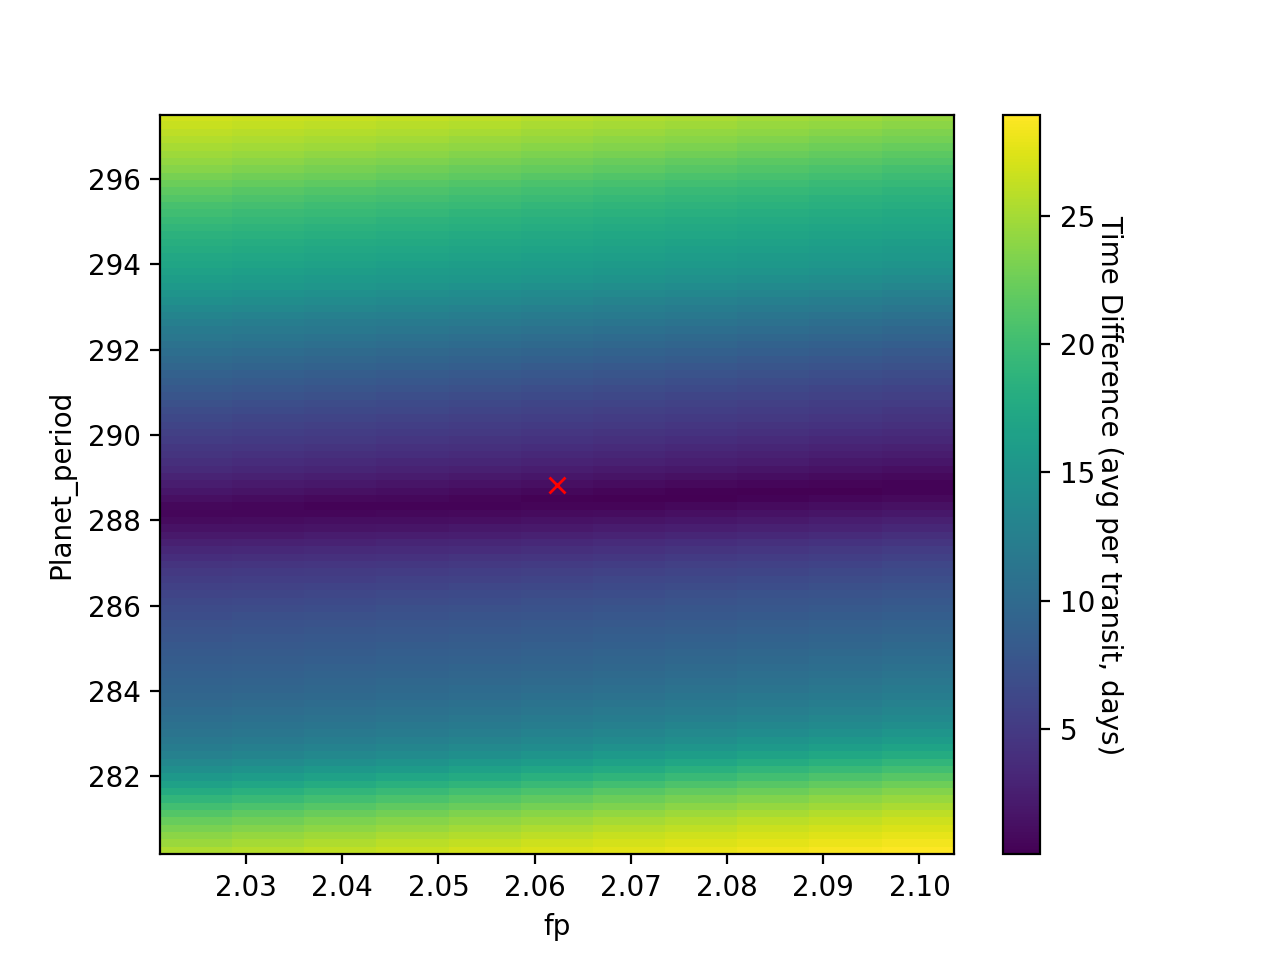

<IPython.core.display.Javascript object>


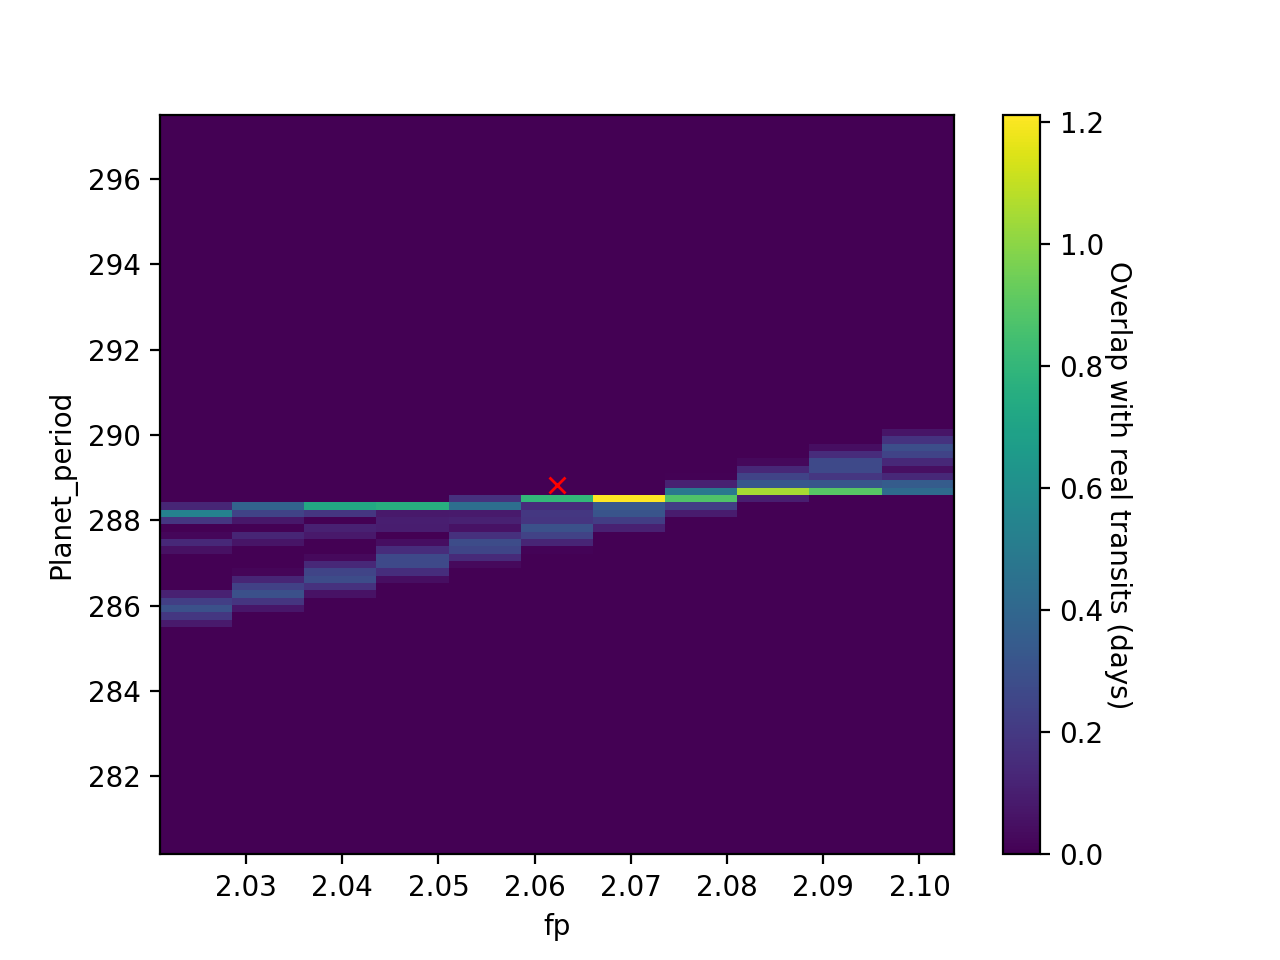

In [26]:
mratidx = 0
mtotidx = 2

#plots
p.figure()
palette = p.cm.viridis
p.imshow(timediffs[mratidx,mtotidx,:,:],origin='lower',
         extent=[np.min(fpset),np.max(fpset),np.min(ppset),np.max(ppset)],
         aspect='auto',cmap=palette)
cbar = p.colorbar()
cbar.set_label('Time Difference (avg per transit, days)', rotation=270, labelpad=10)
p.ylabel('Planet_period')
p.xlabel('fp')
p.plot(fp0,p_p0,'rx')

p.figure()
palette = p.cm.viridis
p.imshow(overlap[mratidx,mtotidx,:,:],origin='lower',
         extent=[np.min(fpset),np.max(fpset),np.min(ppset),np.max(ppset)],
         aspect='auto',cmap=palette)
cbar = p.colorbar()
cbar.set_label('Overlap with real transits (days)', rotation=270, labelpad=10)
p.ylabel('Planet_period')
p.xlabel('fp')
p.plot(fp0,p_p0,'rx')
